In [19]:
import importlib
import sys
import os
import UAVenv
from UAVenv import UAVEnv
importlib.reload(UAVenv)
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 1. 1.]
  [0. 0. 1. 1. 1.]
  [0. 0. 1. 1. 1.]]

 [[1. 1. 1. 0. 0.]
  [1. 1. 1. 0. 0.]
  [1. 1. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 1. 1.]
  [0. 0. 1. 1. 1.]
  [0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 1. 1. 0. 0.]
  [1. 1. 1. 0. 0.]
  [1. 1. 1. 0. 0.]]]
5
8


In [20]:
def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

In [21]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(32 * state_dim * state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # 添加通道维度 (batch, 1, 5, 5) en: add channel dimension (batch, 1, 5, 5)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)
    
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(32 * state_dim * state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # 添加通道维度 (batch, 1, 5, 5) en: add channel dimension (batch, 1, 5, 5)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [28]:
class TRPO:
    """ TRPO算法 """
    # TRPO 
    def __init__(self, hidden_dim, state_dim, action_dim, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_dim
        action_dim = action_dim
        # 策略网络参数不需要优化器更新 en: Policy network parameters do not need optimizer to update
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda  # GAE参数 en: GAE parameter
        self.kl_constraint = kl_constraint  # KL距离最大限制 en: Maximum KL distance constraint
        self.alpha = alpha  # 线性搜索参数 en: Linear search parameter
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def hessian_matrix_vector_product(self, states, old_action_dists, vector):
        # 计算黑塞矩阵和一个向量的乘积 en: Calculate the product of Hessian matrix and a vector
        new_action_dists = torch.distributions.Categorical(self.actor(states))
        kl = torch.mean(
            torch.distributions.kl.kl_divergence(old_action_dists,
                                                 new_action_dists))  # 计算平均KL距离 en: Calculate the average KL distance
        kl_grad = torch.autograd.grad(kl,
                                      self.actor.parameters(),
                                      create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        # KL距离的梯度先和向量进行点积运算 en: The gradient of KL distance is first dot-multiplied with the vector
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product,
                                    self.actor.parameters())
        grad2_vector = torch.cat([grad.reshape(-1) for grad in grad2])
        return grad2_vector

    def conjugate_gradient(self, grad, states, old_action_dists):  # 共轭梯度法求解方程 en: Solve the equation using conjugate gradient method
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):  # 共轭梯度主循环 en: Conjugate gradient main loop
            Hp = self.hessian_matrix_vector_product(states, old_action_dists,
                                                    p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                              actor):  # 计算策略目标 en: Calculate policy objective
        log_probs = torch.log(actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):  # 线性搜索 en: Line search
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(
            self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage,
                                             old_log_probs, self.actor)
        for i in range(15):  # 线性搜索主循环 en: Main loop of line search
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(
                new_para, new_actor.parameters())
            new_action_dists = torch.distributions.Categorical(
                new_actor(states))
            kl_div = torch.mean(
                torch.distributions.kl.kl_divergence(old_action_dists,
                                                     new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                 old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para

    def policy_learn(self, states, actions, old_action_dists, old_log_probs,
                     advantage):  # 更新策略函数 en: Update policy function
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                   old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        # 用共轭梯度法计算x = H^(-1)g en: Use conjugate gradient method to calculate x = H^(-1)g
        descent_direction = self.conjugate_gradient(obj_grad, states,
                                                    old_action_dists)

        Hd = self.hessian_matrix_vector_product(states, old_action_dists,
                                                descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint /
                              (torch.dot(descent_direction, Hd) + 1e-8))
        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)  # 线性搜索 en: Line search
        torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())  # 用线性搜索后的参数更新策略 en: Update policy with parameters after line search

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda,
                                      td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()
        old_action_dists = torch.distributions.Categorical(
            self.actor(states).detach())
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()  # 更新价值函数 en: Update value function
        # 更新策略函数 en: Update policy function
        self.policy_learn(states, actions, old_action_dists, old_log_probs,
                          advantage)

In [29]:
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    return_list_2=[]
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = [{'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []} for _ in range(env.N)]
                state = env.reset()
                done = False
                while not done:
                    actions = [agent.take_action(state[n]) for n in range(env.N)]
                    next_state, reward, done = env.step(actions)
                    for n, uav in enumerate(env.uavs):
                        if uav['done'] == False:
                            transition_dict[n]['states'].append(state[n])
                            transition_dict[n]['actions'].append(actions[n])
                            transition_dict[n]['next_states'].append(next_state[n])
                            transition_dict[n]['rewards'].append(reward[n])
                            transition_dict[n]['dones'].append(done)
                    state = next_state
                    episode_return += sum(reward)
                return_list.append(episode_return)
                return_list_2.append(sum(sum(env.uncertainty_matrix))/100)
                for n in range(env.N):
                    agent.update(transition_dict[n])
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:]),'uncertainty_matrix': '%.3f' % np.mean(return_list_2[-10:])})
                pbar.update(1)
    return return_list , return_list_2

In [30]:
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
critic_lr = 1e-2
kl_constraint = 0.0005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env = UAVEnv()
state_dim = env.state_dim
action_dim =env.action_dim
agent = TRPO(hidden_dim, state_dim, action_dim, lmbda,
             kl_constraint, alpha, critic_lr, gamma, device)
return_list, return_list_2 = train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s, episode=1000, return=1.180, uncertainty_matrix=0.580]


In [32]:
import pickle

# 保存
with open("mtrpo_returns.pkl", "wb") as f:
    pickle.dump((return_list, return_list_2), f)

# 读取
with open("mtrpo_returns.pkl", "rb") as f:
    return_list, return_list_2 = pickle.load(f)

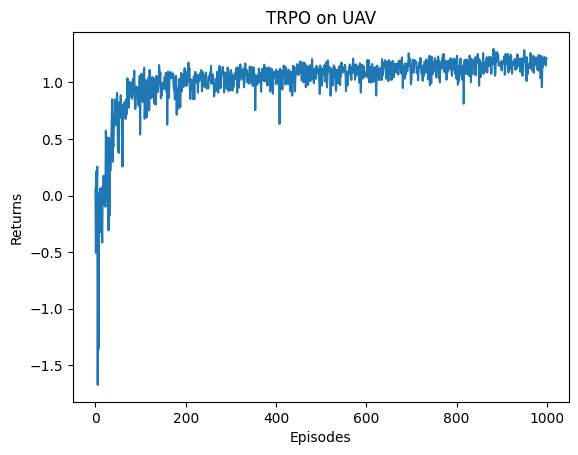

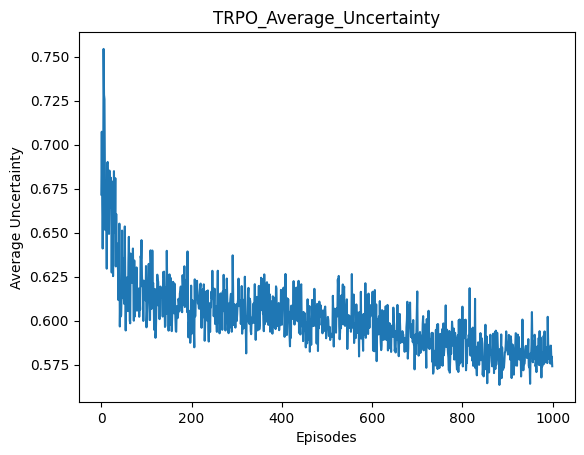

In [33]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on UAV')
plt.show()

episodes_list = list(range(len(return_list_2)))
plt.plot(episodes_list, return_list_2)
plt.xlabel('Episodes')
plt.ylabel('Average Uncertainty')
plt.title('TRPO_Average_Uncertainty')
plt.show()